In [6]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
loan_train = pd.read_csv('./data/Train/Train.csv', index_col='ID')
loan_test = pd.read_csv('./data/Test/Test.csv', index_col='ID')

In [210]:
%run scripts/helper.py
%run scripts/preprocess.py
%run scripts/models.py
%run scripts/metrics.py
%run scripts/ensembling.py

In [9]:
# columns without any missing values
not_nulls = not_null_cols(loan_train)

In [10]:
# columns with type object that don't have any missing values
obj_cols = cols_with_obj_type(loan_train, not_nulls)

In [11]:
obj_cols

['Gender',
 'DOB',
 'Lead_Creation_Date',
 'Mobile_Verified',
 'Var1',
 'Filled_Form',
 'Device_Type',
 'Var2',
 'Source']

In [12]:
loan_train_processed, loan_test_processed = process(loan_train, loan_test, obj_cols)

In [13]:
loan_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87020 entries, ID000002C20 to ID124821V10
Data columns (total 25 columns):
Gender                   87020 non-null int32
City                     86017 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null object
Lead_Creation_Date       87020 non-null object
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null int32
Var5                     87020 non-null int64
Var1                     87020 non-null int32
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted       27726 non-null float64
Filled_Form              87020 

## Exploratory Data Analysis

In [14]:
loan_train.DOB.isnull().any()

False

In [15]:
loan_train.Lead_Creation_Date.isnull().any()

False

In [16]:
cities = loan_train_processed.groupby(['City', 'Disbursed']).size().unstack()

In [17]:
cities.sort(columns=1, ascending=False)

Disbursed,0,1
City,,
Delhi,12258,269
Bengaluru,10645,179
Mumbai,10626,169
Pune,5086,121
Hyderabad,7188,84
Chennai,6849,67
Kolkata,2838,50
Gurgaon,1185,27
Jaipur,1307,24


In [20]:
def to_lower_case(c):
    try:
        if math.isnan(c):
            return c
        else:
            return c.lower()
    except:
        return c
    
loan_train_processed['City'] = loan_train_processed.City.map(to_lower_case)
loan_test_processed['City'] = loan_test_processed.City.map(to_lower_case)

In [21]:
# fill missing values with -1 for City
loan_train_processed.City.fillna('-1', inplace=True)
loan_test_processed.City.fillna('-1', inplace=True)

In [68]:
len(loan_train_processed.Employer_Name.unique())

43568

In [23]:
loan_train_processed['Salary_Account'] = loan_train_processed.Salary_Account.map(to_lower_case)
loan_test_processed['Salary_Account'] = loan_test_processed.Salary_Account.map(to_lower_case)

In [24]:
# fill missing values with -1 for City
loan_train_processed.Salary_Account.fillna('-1', inplace=True)
loan_test_processed.Salary_Account.fillna('-1', inplace=True)

In [69]:
loan_train_processed['Employer_Name'] = loan_train_processed.Employer_Name.map(to_lower_case)
loan_test_processed['Employer_Name'] = loan_test_processed.Employer_Name.map(to_lower_case)

In [70]:
# fill missing values with -1 for Employer's name
loan_train_processed.Employer_Name.fillna('-1', inplace=True)
loan_test_processed.Employer_Name.fillna('-1', inplace=True)

## Data preparation and Cleaning

In [25]:
# encode city names in train and test
loan_train_processed, loan_test_processed = process(loan_train_processed, loan_test_processed, ['City', 'Salary_Account'])

In [74]:
# encode employer's name in train and tet
loan_train_processed, loan_test_processed = process(loan_train_processed, loan_test_processed, ['Employer_Name'])

In [26]:
# fill missing values for loan_amount_applied and loan_tenure_applied
loan_train_processed.Loan_Amount_Applied.fillna(loan_train_processed.Loan_Amount_Applied.median(), inplace=True)
loan_train_processed.Loan_Tenure_Applied.fillna(loan_train_processed.Loan_Tenure_Applied.median(), inplace=True)

loan_test_processed.Loan_Amount_Applied.fillna(loan_test_processed.Loan_Amount_Applied.median(), inplace=True)
loan_test_processed.Loan_Tenure_Applied.fillna(loan_test_processed.Loan_Tenure_Applied.median(), inplace=True)

In [27]:
# fill missing values for loan_amount_applied and loan_tenure_applied
loan_train_processed.Loan_Amount_Submitted.fillna(loan_train_processed.Loan_Amount_Submitted.median(), inplace=True)
loan_train_processed.Loan_Tenure_Submitted.fillna(loan_train_processed.Loan_Tenure_Submitted.median(), inplace=True)

loan_test_processed.Loan_Amount_Submitted.fillna(loan_test_processed.Loan_Amount_Submitted.median(), inplace=True)
loan_test_processed.Loan_Tenure_Submitted.fillna(loan_test_processed.Loan_Tenure_Submitted.median(), inplace=True)

In [28]:
# normalize the monthly income variable
loan_train_processed['Monthly_Income'] = np.log1p(loan_train_processed.Monthly_Income)
loan_test_processed['Monthly_Income'] = np.log1p(loan_test_processed.Monthly_Income)

In [29]:
# fill missing values for existing emis
loan_train_processed.Existing_EMI.fillna(loan_train_processed.Existing_EMI.median(), inplace=True)
loan_test_processed.Existing_EMI.fillna(loan_test_processed.Existing_EMI.median(), inplace=True)

In [30]:
# normalize loan applied amount
loan_train_processed['Loan_Amount_Applied'] = np.log1p(loan_train_processed.Loan_Amount_Applied)
loan_test_processed['Loan_Amount_Applied'] = np.log1p(loan_test_processed.Loan_Amount_Applied)

In [31]:
# normalize loan applied amount
loan_train_processed['Loan_Amount_Submitted'] = np.log1p(loan_train_processed.Loan_Amount_Submitted)
loan_test_processed['Loan_Amount_Submitted'] = np.log1p(loan_test_processed.Loan_Amount_Submitted)

In [32]:
# convert both DOB and Lead_Creation_Date to timestamp
loan_train_processed['DOB'] = pd.to_datetime(loan_train_processed.DOB)
loan_test_processed['DOB'] = pd.to_datetime(loan_test_processed.DOB)

loan_train_processed['Lead_Creation_Date'] = pd.to_datetime(loan_train_processed.Lead_Creation_Date)
loan_test_processed['Lead_Creation_Date'] = pd.to_datetime(loan_test_processed.Lead_Creation_Date)

In [33]:
# calculate age delta for training data
loan_train_processed['age_delta'] = (loan_train_processed.Lead_Creation_Date - loan_train_processed.DOB)

In [34]:
# calculate age delta for testing data
loan_test_processed['age_delta'] = (loan_test_processed.Lead_Creation_Date - loan_test_processed.DOB)

In [189]:
loan_train_processed.Interest_Rate.fillna(loan_train_processed.Interest_Rate.median(), inplace=True)
loan_test_processed.Interest_Rate.fillna(loan_test_processed.Interest_Rate.median(), inplace=True)

In [35]:
# calculate new feature: age of candidate when applying for loan
def get_age_in_years(age):
    seconds = age / (1e9)
    days = seconds / (24. * 60 * 60)
    years = days / 365.
    return int(years)

loan_train_processed['age_when_applied'] = loan_train_processed.age_delta.apply(get_age_in_years)

In [36]:
loan_test_processed['age_when_applied'] = loan_test_processed.age_delta.apply(get_age_in_years)

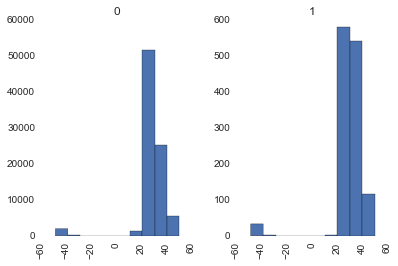

In [37]:
loan_train_processed.hist(column='age_when_applied', by='Disbursed');

In [38]:
loan_train_processed[loan_train_processed.age_when_applied < 0].head()

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed,age_delta,age_when_applied
ID,,,,,,,,,,,,,,,,,,,,,
ID000052A20,1,462,10.933125,2064-05-28,2015-05-01,13.122365,5,14500,TEJCONTROL SYSTEMS PVT LTD,22,...,NaN,0,1,4,10,3,0,0,-17925 days,-49
ID000084G40,1,462,10.714440,2050-05-20,2015-05-01,0.000000,0,0,XHZ,24,...,NaN,0,1,1,10,2,0,0,-12803 days,-35
ID000134E40,0,192,11.928348,2059-10-21,2015-05-01,14.508658,5,37500,B.C.DAS,3,...,NaN,0,1,1,10,3,0,0,-16244 days,-44
ID000196O10,0,66,10.819798,2061-09-10,2015-05-01,12.206078,2,9507,KANCHAN KUMARI,46,...,NaN,0,1,4,10,3,0,0,-16934 days,-46
ID000201T10,0,478,9.798183,2058-01-29,2015-05-01,0.000000,0,0,MUNICIPAL GIRLS HIGH SCHOOL,54,...,10597.55,1,0,2,10,5,0,0,-15614 days,-42


In [39]:
loan_test_processed[loan_test_processed.age_when_applied < 0].head()

,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,Salary_Account,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,age_delta,age_when_applied
ID,,,,,,,,,,,,,,,,,,,,,
ID000492Y20,1,587,10.933125,2059-06-01,2015-05-01,13.815512,5,13000,BHARAT SANCHAR NIGAM LTD,25,...,NaN,NaN,NaN,0,1,1,30,3,-16102 days,-44
ID000862E20,1,381,10.085851,2063-03-15,2015-05-01,12.611541,4,0,WEST BENGAL STATE ELECTRICITY DISTRIBUTION LTD,56,...,20.0,3000,9129.11,1,1,1,20,5,-17485 days,-47
ID001389L40,0,638,11.512935,2053-06-01,2015-05-02,14.220976,5,0,SINHGAD INSTITUTE,7,...,NaN,NaN,NaN,0,1,1,10,1,-13910 days,-38
ID001458C30,1,249,11.225257,2056-08-11,2015-05-02,13.815512,4,0,PEARL BEVERAGES LTD,58,...,NaN,NaN,NaN,0,1,1,10,3,-15077 days,-41
ID001763V30,1,462,10.434145,2057-08-17,2015-05-02,0.000000,0,0,WESTERN RAILWAY,46,...,15.5,2650,12748.19,1,0,2,10,5,-15448 days,-42


### Model Building

In [191]:
features = loan_train_processed[['City', 'Salary_Account', 'Interest_Rate', 'Employer_Name', 'Monthly_Income','Var5', 
                                 'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                                 'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                                 'Var1', 'Source', 'Var5', 'age_when_applied']]

In [192]:
from sklearn.cross_validation import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(loan_train.Disbursed, n_iter=3, test_size=0.3, random_state=121)

In [193]:
train_idx, test_idx = next(iter(sss))

In [194]:
Xt = features.iloc[train_idx]
Xv = features.iloc[test_idx]

yt = loan_train.Disbursed.iloc[train_idx]
yv = loan_train.Disbursed.iloc[test_idx]

In [195]:
# Random Forest Classifier
model_rf = random_forest_classifier(Xt, yt)

In [211]:
# Gradient Boosting Classifier
model = gradient_boosting_classifier(Xt, yt)

In [197]:
model_rf

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [212]:
model

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [199]:
yt_pred_rf = predictions(model_rf, Xt)[:, 1]
print 'ROC AUC score on the training set for Random Forest Classifier %f ' %(score(yt, yt_pred_rf))

ROC AUC score on the training set for Random Forest Classifier 0.999945 


In [213]:
yt_pred_gbr = predictions(model, Xt)[:, 1]
print 'ROC AUC score on the training set for GBC %f ' %(score(yt, yt_pred_gbr))

ROC AUC score on the training set for GBC 0.884661 


In [201]:
yt_pred_ensemble = (.5 * yt_pred_rf + .5 * yt_pred_gbr)
print 'ROC AUC score on the training set for ensemble %f ' %(score(yt, yt_pred_ensemble))

ROC AUC score on the training set for ensemble 0.999932 


In [1011]:
train_blending_submission = stacked_blending(Xt.values, yt.values, Xv.values)

Creating train and test sets for blending.
0 RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Fold 0
[30410 30411 30412 ..., 60911 60912 60913]
Fold 1
[    0     1     2 ..., 32409 32448 32451]
1 GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              random_state=None, subsample=0.9, verbose=0,
              warm_start=False)
Fold 0
[30410 30411 30412 ..., 60911 60912 60913]
Fold 1
[    0     1     2 ..., 32409 32448 32451]

Blending.
Linear stretch of predictions to 

In [1012]:
print 'ROC score %f ' %(score(yv, train_blending_submission))

ROC score 0.832172 


### Validation set

yv_pred_rf = predictions(model_rf, Xv)[:, 1]
print 'ROC AUC score on the test set for Random Forest Classifier %f ' %(score(yv, yv_pred_rf))

In [215]:
yv_pred = predictions(model, Xv)[:, 1]
print 'ROC AUC score on the test set for GBC %f ' %(score(yv, yv_pred))

ROC AUC score on the test set for GBC 0.838680 


In [216]:
yv_pred_ensemble = (.2 * yv_pred_rf + .8 * yv_pred)
print 'ROC AUC score on the test set for ensemble %f ' %(score(yv, yv_pred_ensemble))

ROC AUC score on the test set for ensemble 0.840005 


### Final Model

In [205]:
features_test = loan_test[['City', 'Salary_Account', 'Interest_Rate', 'Employer_Name', 'Monthly_Income','Var5', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1','Source', 'Var5', 'age_when_applied']]

In [206]:
model_final_rf = random_forest_classifier(features, loan_train_processed.Disbursed)
model_final_gbr = gradient_boosting_classifier(features, loan_train_processed.Disbursed)

In [207]:
final_preds_rf = predictions(model_final_rf, features_test)[:, 1]
final_preds_gbr = predictions(model_final_gbr, features_test)[:, 1]

In [208]:
final_preds = (.2 * final_preds_rf + .8 * final_preds_gbr)

In [209]:
create_submission_file(loan_test.index.values, final_preds, 'ensemble_rf_gbr_features_ir.csv')

## Feature Selection

In [108]:
%run scripts/feature_selection.py

In [109]:
feature_selection(loan_train_processed[['City', 'Salary_Account', 'Employer_Name', 'Monthly_Income','Var5', 
                           'Loan_Amount_Applied', 'Loan_Tenure_Applied', 
                           'Existing_EMI', 'Loan_Amount_Submitted', 'Loan_Tenure_Submitted',
                           'Var1', 'Filled_Form', 'Device_Type', 'Var2', 'Source', 'Var5', 'age_when_applied']], 
                  loan_train_processed.Disbursed)

initial f1 score based on extra trees classifier:  0.0
feature importance:  [ 0.09203676  0.08384553  0.11182189  0.11072908  0.04303247  0.05550208
  0.03880343  0.08399025  0.0735262   0.03622075  0.04435319  0.01275061
  0.00250464  0.02240173  0.04466838  0.04152769  0.10228534]
sorted feature importances:  [ 0.11182189  0.11072908  0.10228534  0.09203676  0.08399025  0.08384553
  0.0735262   0.05550208  0.04466838  0.04435319  0.04303247  0.04152769
  0.03880343  0.03622075  0.02240173  0.01275061  0.00250464]
output format:
no of features, f1-score, roc-score of class-predictions, roc-score of probabilities
1 0.00481927710843 0.500686913274 0.564706467202
2 0.00497512437811 0.500939595594 0.809889017203
3 0.00502512562814 0.501017344 0.809101102236
4 0.01 0.502306807422 0.812684448935
5 0.0102301790281 0.502481741336 0.81692275472
6 0.00516795865633 0.501231152117 0.823756982092
7 0.0 0.499727880578 0.826796089947
8 0.0 0.499825066086 0.828271528778
9 0.0 0.49974731768 0.83190295

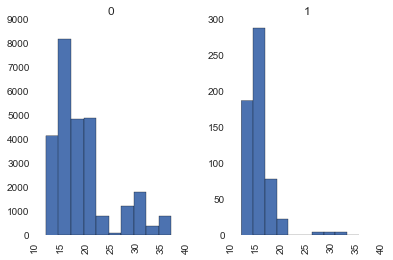

In [177]:
loan_train_processed.hist(column='Interest_Rate', by='Disbursed');

In [180]:
loan_train_processed.Interest_Rate.mean()

19.197474211931041

In [181]:
loan_train_processed.Interest_Rate.median()

18.0